In [1]:


import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [5]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [3]:
"""
This is my implementation of micrograd by the smart Machine Learning guy with the russian name
"""


import math


class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data =  data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out 
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward 

        return out
    def __rmul__(self, other): #if a.__mul__(b) is not working perform b.__mul__(a)
        return other * self
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
   
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward() 



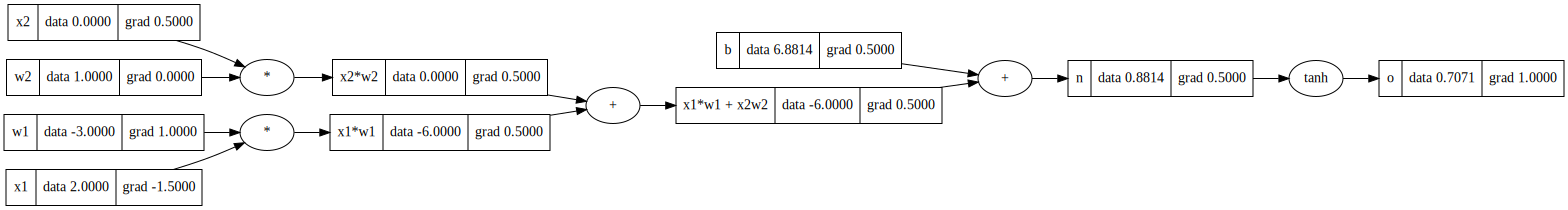

In [6]:
x1 = Value (2.0, label = "x1")
x2 = Value (0.0, label = "x2")

w1 = Value(-3.0, label= "w1")
w2 = Value(1.0, label= "w2")

b = Value(6.8813735870195432); b.label = "b"
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
o.backward()
draw_dot(o)


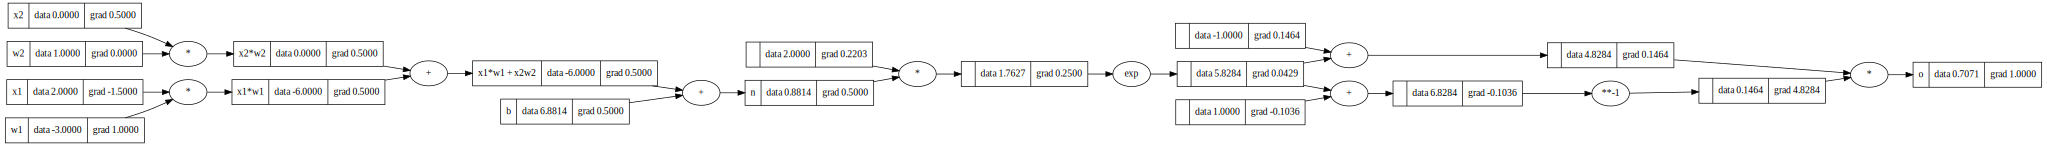

In [7]:
x1 = Value (2.0, label = "x1")
x2 = Value (0.0, label = "x2")

w1 = Value(-3.0, label= "w1")
w2 = Value(1.0, label= "w2")

b = Value(6.8813735870195432); b.label = "b"
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
####
e = (2*n).exp()
o = (e - 1) * (e + 1) ** -1
####
o.label = "o"
o.backward()
draw_dot(o)


In [8]:
import torch

In [9]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


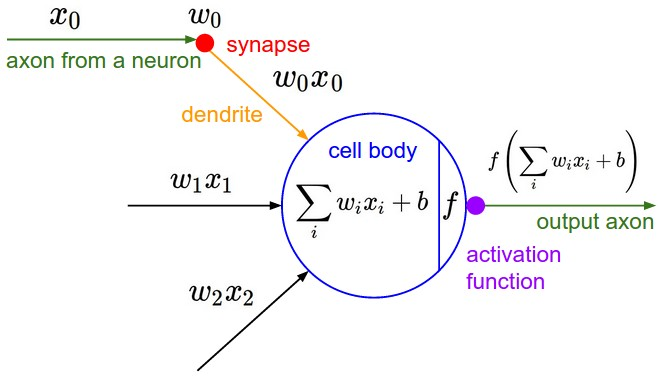

In [13]:
from IPython.display import Image
Image("neuron_model.jpeg")

In [62]:
from typing import Any


class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
    

Value(data = -0.8593114988226396)

In [88]:
x = [2.0, 4.0]
n = MLP(2, [3, 3, 1])
n(x)

Value(data = 0.588866851319341)

In [89]:
print(len(n.parameters()))
n.parameters()

25


[Value(data = -0.19809108736721037),
 Value(data = -0.09039031739823433),
 Value(data = -0.21847988755242387),
 Value(data = -0.4147443856370645),
 Value(data = -0.04312773489357524),
 Value(data = 0.7805381722562499),
 Value(data = 0.7210714476437037),
 Value(data = 0.5437092444595277),
 Value(data = -0.23276985722699273),
 Value(data = -0.4771086187509812),
 Value(data = -0.6719637204568814),
 Value(data = 0.6328868153026506),
 Value(data = 0.38744776410877146),
 Value(data = 0.8815714120195581),
 Value(data = 0.10905996562291831),
 Value(data = -0.630878254333443),
 Value(data = 0.4166635906846785),
 Value(data = 0.39881302284261766),
 Value(data = 0.3502091364443798),
 Value(data = 0.7609953211399392),
 Value(data = -0.3316312597194959),
 Value(data = 0.7245803607758297),
 Value(data = 0.38380518277354403),
 Value(data = 0.6642555436212272),
 Value(data = 0.25748914965313663)]

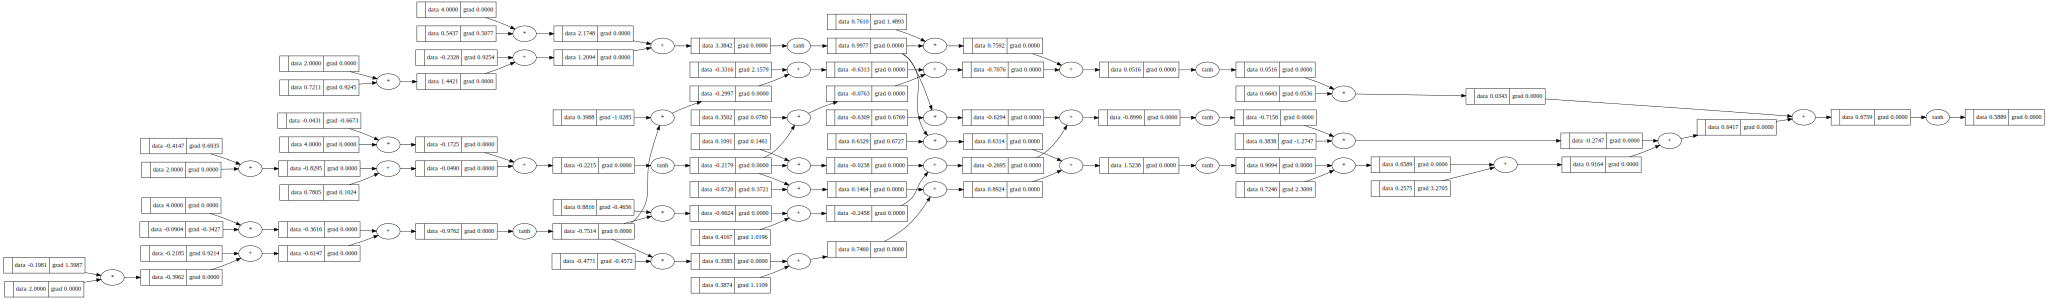

In [96]:
draw_dot(n(x))

In [91]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] #data set with 4 examples
ys = [1.0, -1.0, -1.0, 1.0] # desired targets / labels => Very simple binary classifier

ypred = [n(x) for x in xs]
ypred

[Value(data = 0.6020060958892873),
 Value(data = 0.5683870478759099),
 Value(data = 0.571856795907005),
 Value(data = 0.6231348954657033)]

In [92]:
ypred = [n(x) for x in xs]
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data = 5.2309981735088815)

In [93]:
loss.backward()

In [99]:
n.layers[0].neurons[0].w[0].grad

0.6934626076245007

In [100]:
n.layers[0].neurons[0].w[0].data

-0.4147443856370645

In [101]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [102]:
n.layers[0].neurons[0].w[0].data

-0.21407775990314631

In [109]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 0.016042989487027405
1 0.015753729911666976
2 0.015474160552870342
3 0.015203813063781216
4 0.014942248455842388
5 0.014689054848678487
6 0.014443845423120178
7 0.014206256556308165
8 0.013975946120280133
9 0.013752591927584051
10 0.013535890309328504
11 0.01332555481271399
12 0.013121315006516327
13 0.01292291538424779
14 0.01273011435582417
15 0.012542683319535028
16 0.012360405806973129
17 0.01218307669433439
18 0.01201050147417131
19 0.011842495582276603
